In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek

In [4]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
0,2022-01-01,36,2201.722967,56208.538497,4342,5
1,2022-01-02,11,-164.573991,48039.620299,3836,6
2,2022-01-03,12,-147.260111,19233.123874,1630,0
3,2022-01-04,10,1064.457361,61688.730570,1664,1
4,2022-01-05,16,1601.138453,28191.484771,2257,2


#### Heads прогнозирование

<Axes: xlabel='Date'>

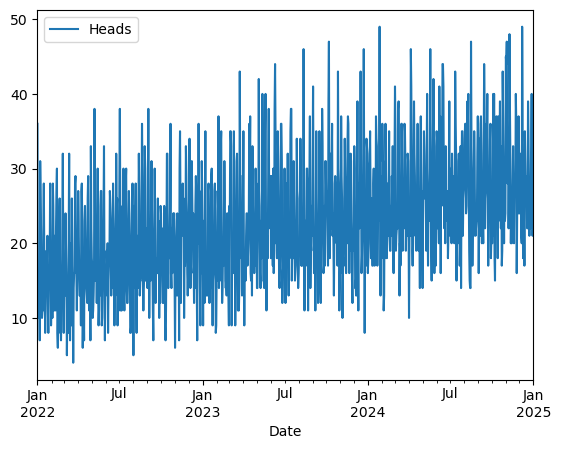

In [5]:

casino_fig[:].plot(x="Date", y ="Heads")


### Разделяем на тренингувую и тестовую выборку

In [6]:
casino_fig_train = casino_fig[casino_fig['Date'] < datetime(2024,11,1) ]
casino_fig_test = casino_fig[casino_fig['Date'] >= datetime(2024,11,1) ]

In [7]:
casino_fig_test.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1035,2024-11-01,45,6838.419943,117920.679925,5804,4
1036,2024-11-02,44,-2107.091245,83828.558835,4999,5
1037,2024-11-03,47,-3082.262993,89961.891744,4337,6
1038,2024-11-04,32,-485.157534,74227.738308,3962,0
1039,2024-11-05,28,2701.131858,62278.374150,2184,1


In [8]:
casino_fig_train.tail()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,week_day
1030,2024-10-27,30,3814.618326,113176.503225,5723,6
1031,2024-10-28,20,156.495246,34330.555529,2708,0
1032,2024-10-29,29,2233.173779,60716.530362,3756,1
1033,2024-10-30,23,122.454071,67128.136147,3938,2
1034,2024-10-31,24,1013.210431,40839.245035,3740,3


### Вычисляем Тренд

In [9]:
coefficients = np.polyfit(casino_fig_train.index,casino_fig_train['Heads'], 1)
print(coefficients)

[1.19798379e-02 1.63098055e+01]


In [10]:
poly_1 = np.poly1d(coefficients)

In [11]:
casino_fig_train['trend_heads']= poly_1(casino_fig_train.index)

<Axes: xlabel='Date'>

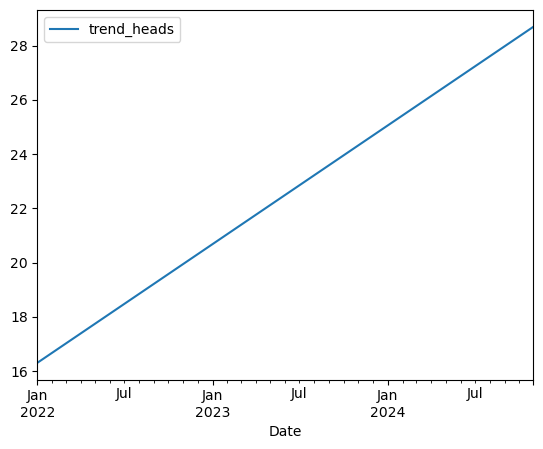

In [12]:
casino_fig_train.plot(x="Date", y ="trend_heads")

### Очищаем от тренда

In [13]:
casino_fig_train['heads_center_and_clear']=casino_fig_train['Heads']-casino_fig_train['trend_heads']

<Axes: xlabel='Date'>

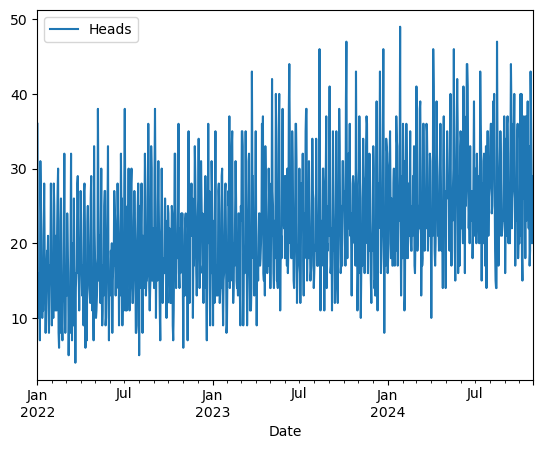

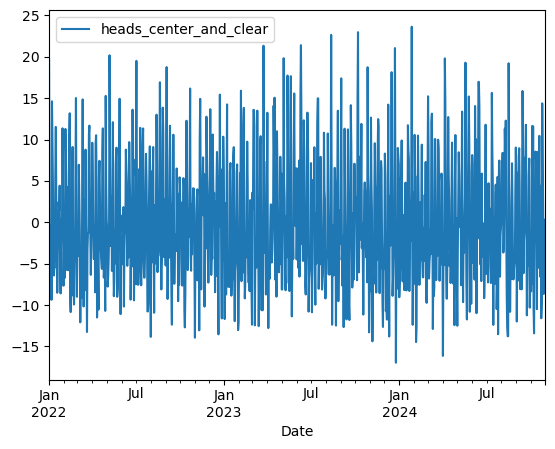

In [14]:
casino_fig_train.plot(x="Date", y ="Heads")
casino_fig_train.plot(x="Date", y ="heads_center_and_clear")

In [15]:
heads_train_df =casino_fig_train.groupby('week_day')['heads_center_and_clear'].agg([ 'mean','std'])

In [16]:
heads_train_df

,mean,std
week_day,,
0,-7.233878,4.058281
1,-4.732345,4.656745
2,-3.115946,4.031603
3,-4.053602,4.368277
4,7.190496,5.290557
5,9.384676,5.565349
6,2.609183,4.963465


### Добавляем тренд в тестовую выборку (для удобства его учёта при прогнозировании)

In [17]:
casino_fig_test['trend_heads']= poly_1(casino_fig_test.index)

### Делаем прогноз

In [18]:
predict = []
predict_3_std_plus = []
predict_3_std_minus = []
for curr_ind in casino_fig_test.index:
    week_day = casino_fig_test['week_day'].loc[curr_ind]
    trend = casino_fig_test['trend_heads'].loc[curr_ind]
    pred = trend + heads_train_df['mean'].loc[week_day]
    predict.append(pred)
    predict_3_std_plus.append(pred+3*heads_train_df['std'].loc[week_day])
    predict_3_std_minus.append(pred-3*heads_train_df['std'].loc[week_day])
    

In [19]:
casino_fig_test['predict'] = predict
casino_fig_test['predict_3_std_plus'] = predict_3_std_plus
casino_fig_test['predict_3_std_minus'] = predict_3_std_minus

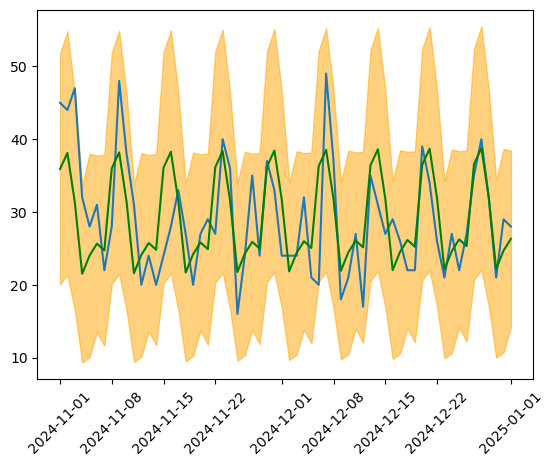

In [21]:
plt.plot(casino_fig_test['Date']  ,casino_fig_test['Heads'] )
plt.plot(casino_fig_test['Date'],casino_fig_test['predict'],color='green' )
plt.fill_between(casino_fig_test['Date'], casino_fig_test['predict_3_std_minus'], casino_fig_test['predict_3_std_plus'], alpha=0.5, color='orange')
plt.tick_params(axis='x', labelrotation=45)